In [3]:
import os
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras.preprocessing import image
import numpy as np

In [4]:
cat_train_path = "../input/cat-and-dog/training_set/training_set/cats/"
cat_test_path = "../input/cat-and-dog/test_set/test_set/cats/"

cat_train = []
for filename in os.listdir(cat_train_path):
    if filename.endswith(".jpg"):
        img = image.load_img(cat_train_path+filename, target_size=(128, 128))
        cat_train.append(image.img_to_array(img))
cat_train = np.array(cat_train)

cat_test = []
for filename in os.listdir(cat_test_path):
    if filename.endswith(".jpg"):
        img = image.load_img(cat_test_path+filename, target_size=(128, 128))
        cat_test.append(image.img_to_array(img))
cat_test = np.array(cat_test)

In [5]:
print("cat_train", cat_train.shape)
print("cat_test", cat_test.shape)

cat_train (4000, 128, 128, 3)
cat_test (1011, 128, 128, 3)


# *Visualize the cats*

In [6]:
def show_cat_data(X, n=10, title=""):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

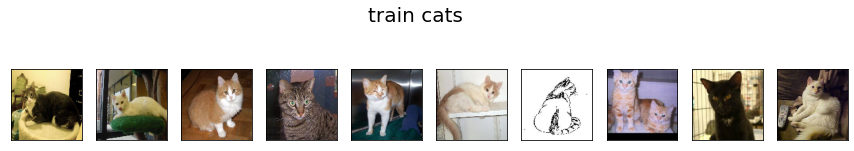

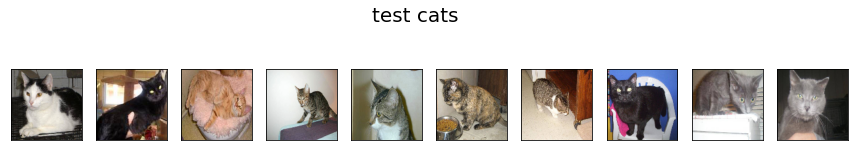

In [7]:
show_cat_data(cat_train, title="train cats")
show_cat_data(cat_test, title="test cats")

# *Build the cat Autoencoder*

In [8]:
input_layer = Input(shape=(128, 128, 3), name="INPUT")
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

code_layer = MaxPooling2D((2, 2), name="CODE")(x)

x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(code_layer)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
output_layer = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [9]:
cat_AE = Model(input_layer, output_layer)
cat_AE.compile(optimizer='adam', loss='mse')
cat_AE.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
CODE (MaxPooling2D)          (None, 16, 16, 8)         0   

# *Train the cat Autoencoder*

In [21]:
cat_AE.fit(cat_train, cat_train,
                epochs=30,
                batch_size=32,
                shuffle=True,
                validation_data=(cat_test, cat_test))

Train on 4000 samples, validate on 1011 samples
Epoch 1/30
4000/4000 [==============================] - 73s 18ms/step - loss: 567.3618 - val_loss: 570.7072
Epoch 2/30
4000/4000 [==============================] - 72s 18ms/step - loss: 557.3309 - val_loss: 564.4040
Epoch 3/30
4000/4000 [==============================] - 73s 18ms/step - loss: 548.2017 - val_loss: 553.6704
Epoch 4/30
4000/4000 [==============================] - 73s 18ms/step - loss: 542.9501 - val_loss: 547.3530
Epoch 5/30
4000/4000 [==============================] - 73s 18ms/step - loss: 533.5163 - val_loss: 550.8933
Epoch 6/30
4000/4000 [==============================] - 72s 18ms/step - loss: 527.5758 - val_loss: 532.7669
Epoch 7/30
4000/4000 [==============================] - 74s 18ms/step - loss: 521.8233 - val_loss: 528.6647
Epoch 8/30
4000/4000 [==============================] - 72s 18ms/step - loss: 518.4230 - val_loss: 522.9504
Epoch 9/30
4000/4000 [==============================] - 72s 18ms/step - loss: 512.9431 -

# *Save model*

In [22]:
cat_AE.save("cat_AE.h5")

# *Make a model to get the encoded representation (i.e. intermediate layer output) for a given cat image.*

In [23]:
get_encoded_cat = Model(inputs=cat_AE.input, outputs=cat_AE.get_layer("CODE").output)

# *Get the encoded cats*

In [24]:
encoded_cat = get_encoded_cat.predict(cat_test)
encoded_cat = encoded_cat.reshape((len(cat_test), 16*16*8))
encoded_cat.shape

(1011, 2048)

# *Get the reconstructed cats*

In [25]:
reconstructed_cats = cat_AE.predict(cat_test)

# *Visualize the results on test set*

In [26]:
def show_cat_data(X, n=10, title=""):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

In [27]:
def show_data(X, n=10, height=28, width=28, title=""):
    plt.figure(figsize=(10, 3))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(X[i].reshape((height,width)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

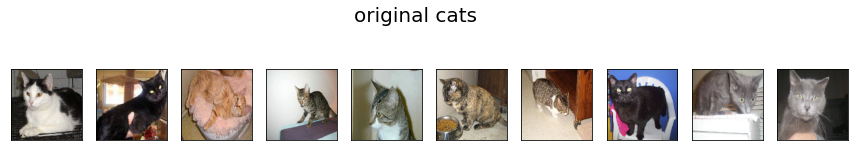

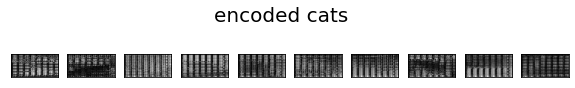

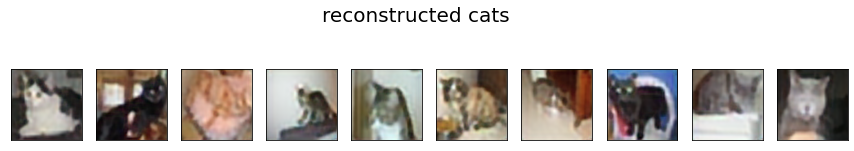

In [28]:
show_cat_data(cat_test, title="original cats")
show_data(encoded_cat, height=32, width=64, title="encoded cats")
show_cat_data(reconstructed_cats, title="reconstructed cats")

---